In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots, bmk, dvcs
import gepard.plots as gplot
from gepard import constants
from gepard.fits import GLO15new, AUTIpts, ALUIpts, ACpts, AULpts, ALLpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
#import shelve, logging, copy
#logging.basicConfig(level=logging.ERROR) 
#import pandas as pd 
#from scipy.integrate import quad
#from scipy.interpolate import InterpolatedUnivariateSpline
#from scipy.stats import norm
from tqdm import tqdm

In [4]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')

import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [5]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [6]:
# Define file paths
RESULTS_DIR = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/Results/Test'
FITS_DIR = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test'

In [7]:
fitpoints = (
    g.dset.get(101, []) + g.dset.get(102, []) + g.dset.get(8, []) + 
    g.dset.get(81, []) + g.dset.get(94, []) + g.dset.get(95, []) + g.dset.get(96, []) 
    + mydset.get(182, []) + mydset.get(192, []) 
    + ACpts+ AULpts + ALLpts 
    #+ mydset.get(251, [])
)   
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
 6 x AC      HERMES  0.0    67  arXiv:1203.6287 [hep-ex]
 6 x AC      HERMES  1.0    67  arXiv:1203.6287 [hep-ex]
 8 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
 8 x ALU     CLAS    -1     192 arxiv:2211.11274
10 x ALU     CLAS    -1     94  arXiv:1501.07052
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
 6 x ALU     CLAS    -1.0   81  arXiv:0812.2950
 6 x ALU     CLAS    -2.0   81  arXiv:0812.2950
10 x BTSA    CLAS    0.0    96  arXiv:1501.07052
10 x BTSA    CLAS    1.0    96  arXiv:1501.07052
 4 x BTSA    HERMES  0.0    53  arXiv:1004.0177v1
 3 x TSA     CLAS    -1     54  arXiv:hep-ex/0605012
10 x TSA     CLAS    -1     95  arXiv:1501.07052
 4 x TSA     HERMES  -1.0   52  arXiv:1004.0177v1
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------


In [8]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BM10):    

    def build_net(self):
            '''Overriding the default architecture and optimizer'''
            nn_model = torch.nn.Sequential(
                    torch.nn.Linear(2, 23),
                    torch.nn.ReLU(),
                    torch.nn.Linear(23, 37),
                    torch.nn.ReLU(),
                    torch.nn.Linear(37, 19),
                    torch.nn.ReLU(),
                    torch.nn.Linear(19, len(self.output_layer))
                )
            optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.001 ) #lr=0.05 #2e-3
            return nn_model, optimizer

# Loading a single model

In [9]:
def load_model_ensemble(path, model_class, name="Loaded Model"):
    """
    Load a saved ensemble model from a .pt file and restore the `th_model` instance.

    Parameters:
    -----------
    path : str
        Path to the saved .pt file.
    model_class : class
        The class used to define the model (e.g., `NNTest_DR`).
    name : str
        A display name for the model, used for plots or printing.

    Returns:
    --------
    th_model : instance of model_class
        Restored model with `.nets` loaded and ready to use.
    metadata : dict
        Dictionary with optional metadata (history, test_history, etc.).
    """
    data = torch.load(path)

    # Create model instance
    th_model = model_class(output_layer=data.get('output_layer', []))
    th_model.name = name
    th_model.nets = data['nets']  # List of (model, mean, std)

    # Additional optional metadata
    metadata = {
        'history': data.get('history', None),
        'test_history': data.get('test_history', None),
        'output_layer': data.get('output_layer', None),
    }

    return th_model, metadata

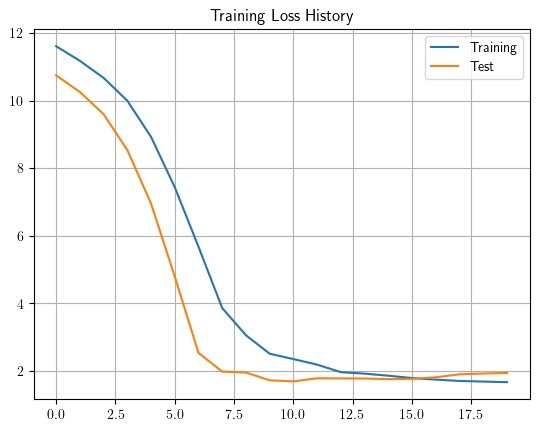

In [10]:
# Load a saved DR model ensemble
path = os.path.join(FITS_DIR, 'nets_NoDR_1.pt')
th, meta = load_model_ensemble(path, NNTest, name="Fit NoDR")

# Access training history
if meta['history']:
    plt.plot(meta['history'], label="Training")
    plt.plot(meta['test_history'], label="Test")
    plt.legend()
    plt.title("Training Loss History")
    plt.grid()
    plt.show()

# Now you can use:
# gplot.CFF3(cffs=[...], mesh=th_dr, ...)
# th_dr.nets[i][0](x)  ← access specific network model

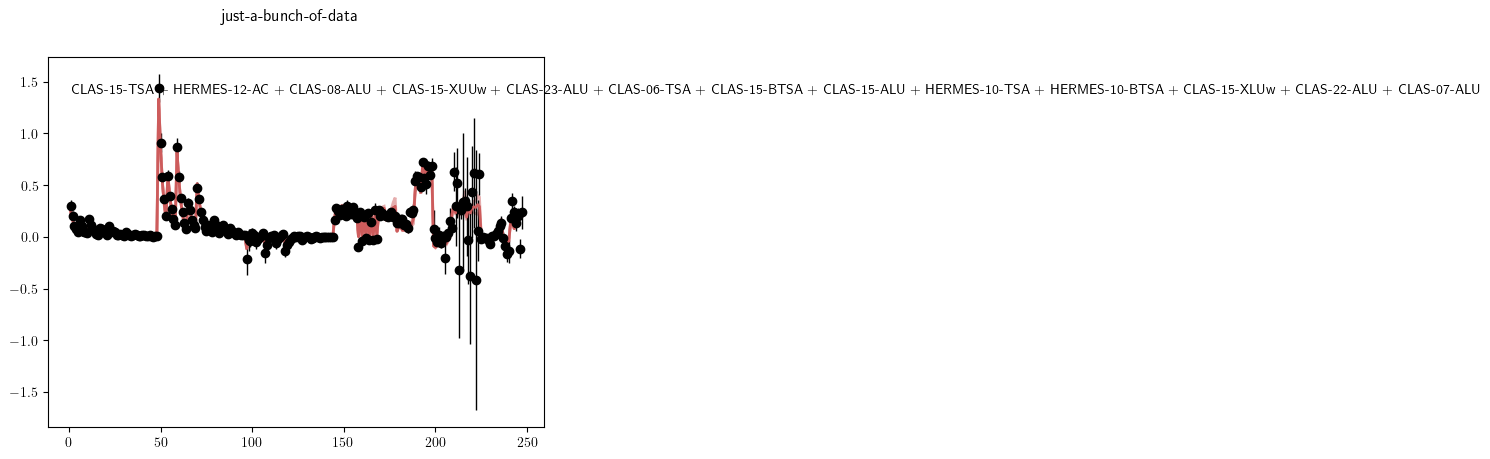

In [11]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

# Ensemble - Mean and Std vs models and nets

In [12]:
# --- Settings ---
ensembleSize = 20  # Number of trained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_labels = ['ImH', 'ReH', 'ImE', 'ReE']

# --- Prepare inputs ---
Data_points = np.array([[dp.xB, dp.t] for dp in fitpoints])  # (n_points, 2)
Data_pointsy = np.array([dp.val for dp in fitpoints])        # (n_points,)
Data_points_err = np.array([dp.err for dp in fitpoints])      # (n_points,)

In [13]:
# ===============================================================
# STEP 1: Analyze ensemble treating EACH NET individually
# ===============================================================

print("\n📊 Step 1: Evaluating ensemble over individual nets...")

all_net_predictions = []  # (n_total_nets, n_points, n_outputs)

for i in tqdm(range(1, ensembleSize + 1), desc="Processing nets"):
    path = os.path.join(FITS_DIR, f'nets_NoDR_{i}.pt')
    checkpoint = torch.load(path, map_location=device)

    nets = checkpoint['nets']  # list of (net, mean, std)

    for net, mean, std in nets:
        net = net.to(device)
        net.eval()

        inputs = torch.tensor(Data_points, dtype=torch.float32).to(device)
        x_standardized = (inputs - mean) / (std + 1e-7)
        preds = net(x_standardized).detach().cpu().numpy()

        all_net_predictions.append(preds)

ensemble_predictions_nets = np.stack(all_net_predictions)  # (n_total_nets, n_points, n_outputs)

print(f"✅ Ensemble predictions shape (nets): {ensemble_predictions_nets.shape}")

# ===============================================================
# STEP 2: Analyze ensemble treating EACH MODEL (mean of nets)
# ===============================================================

print("\n📊 Step 2: Evaluating ensemble over model averages...")

all_model_predictions = []  # (n_models, n_points, n_outputs)

for i in tqdm(range(1, ensembleSize + 1), desc="Processing models"):
    path = os.path.join(FITS_DIR, f'nets_NoDR_{i}.pt')
    checkpoint = torch.load(path, map_location=device)

    nets = checkpoint['nets']

    model_preds = []

    for net, mean, std in nets:
        net = net.to(device)
        net.eval()

        inputs = torch.tensor(Data_points, dtype=torch.float32).to(device)
        x_standardized = (inputs - mean) / (std + 1e-7)
        preds = net(x_standardized).detach().cpu().numpy()

        model_preds.append(preds)

    model_preds = np.stack(model_preds)  # (n_nets, n_points, n_outputs)
    model_mean_preds = np.mean(model_preds, axis=0)  # (n_points, n_outputs)

    all_model_predictions.append(model_mean_preds)

ensemble_predictions_models = np.stack(all_model_predictions)  # (n_models, n_points, n_outputs)

print(f"✅ Ensemble predictions shape (models): {ensemble_predictions_models.shape}")


📊 Step 1: Evaluating ensemble over individual nets...


Processing nets: 100%|██████████| 20/20 [00:00<00:00, 58.89it/s] 


✅ Ensemble predictions shape (nets): (1000, 247, 4)

📊 Step 2: Evaluating ensemble over model averages...


Processing models: 100%|██████████| 20/20 [00:00<00:00, 55.40it/s]

✅ Ensemble predictions shape (models): (20, 247, 4)


In [14]:
# ===============================================================
# STEP 3: Utility Functions for Analysis
# ===============================================================

def remove_entries(arr, n_remove):
    if n_remove < arr.shape[0]:
        indices_to_remove = np.random.choice(arr.shape[0], n_remove, replace=False)
        return np.delete(arr, indices_to_remove), True
    return arr, False

def get_residuals_single_output(ensemble_preds, y_true, current_idx, output_idx):
    pred_mean = np.mean(ensemble_preds[current_idx, :, output_idx], axis=0)
    residual = y_true - pred_mean
    r_mean = np.mean(residual)
    r_std = np.std(residual)
    return r_mean, r_std

def evaluate_ensemble_behavior(ensemble_preds, y_true, n_remove, n_trials, output_labels, title_prefix):
    n_ensemble, n_points, n_outputs = ensemble_preds.shape
    fig, axs = plt.subplots(n_outputs, 2, figsize=(14, 4 * n_outputs))

    for output_idx in range(n_outputs):
        for trial in range(n_trials):
            sizes = []
            residuals_mean = []
            residuals_std = []

            idx = np.arange(n_ensemble)
            sizes.append(idx.shape[0])

            r_mean, r_std = get_residuals_single_output(ensemble_preds, y_true, idx, output_idx)
            residuals_mean.append(r_mean)
            residuals_std.append(r_std)

            keep_removing = True
            while keep_removing and idx.shape[0] > 2:
                idx, keep_removing = remove_entries(idx, n_remove)
                r_mean, r_std = get_residuals_single_output(ensemble_preds, y_true, idx, output_idx)
                residuals_mean.append(r_mean)
                residuals_std.append(r_std)
                sizes.append(idx.shape[0])

            axs[output_idx, 0].plot(sizes, residuals_mean, '-o', alpha=0.6)
            axs[output_idx, 1].plot(sizes, residuals_std, '-o', alpha=0.6)

        axs[output_idx, 0].set_title(f"{title_prefix}: Mean Residuals ({output_labels[output_idx]})")
        axs[output_idx, 1].set_title(f"{title_prefix}: Std Residuals ({output_labels[output_idx]})")
        axs[output_idx, 0].grid(True)
        axs[output_idx, 1].grid(True)
        axs[output_idx, 0].set_xlabel("Ensemble size")
        axs[output_idx, 1].set_xlabel("Ensemble size")

    plt.tight_layout()
    plt.show()


📈 Plotting ensemble behavior over nets...


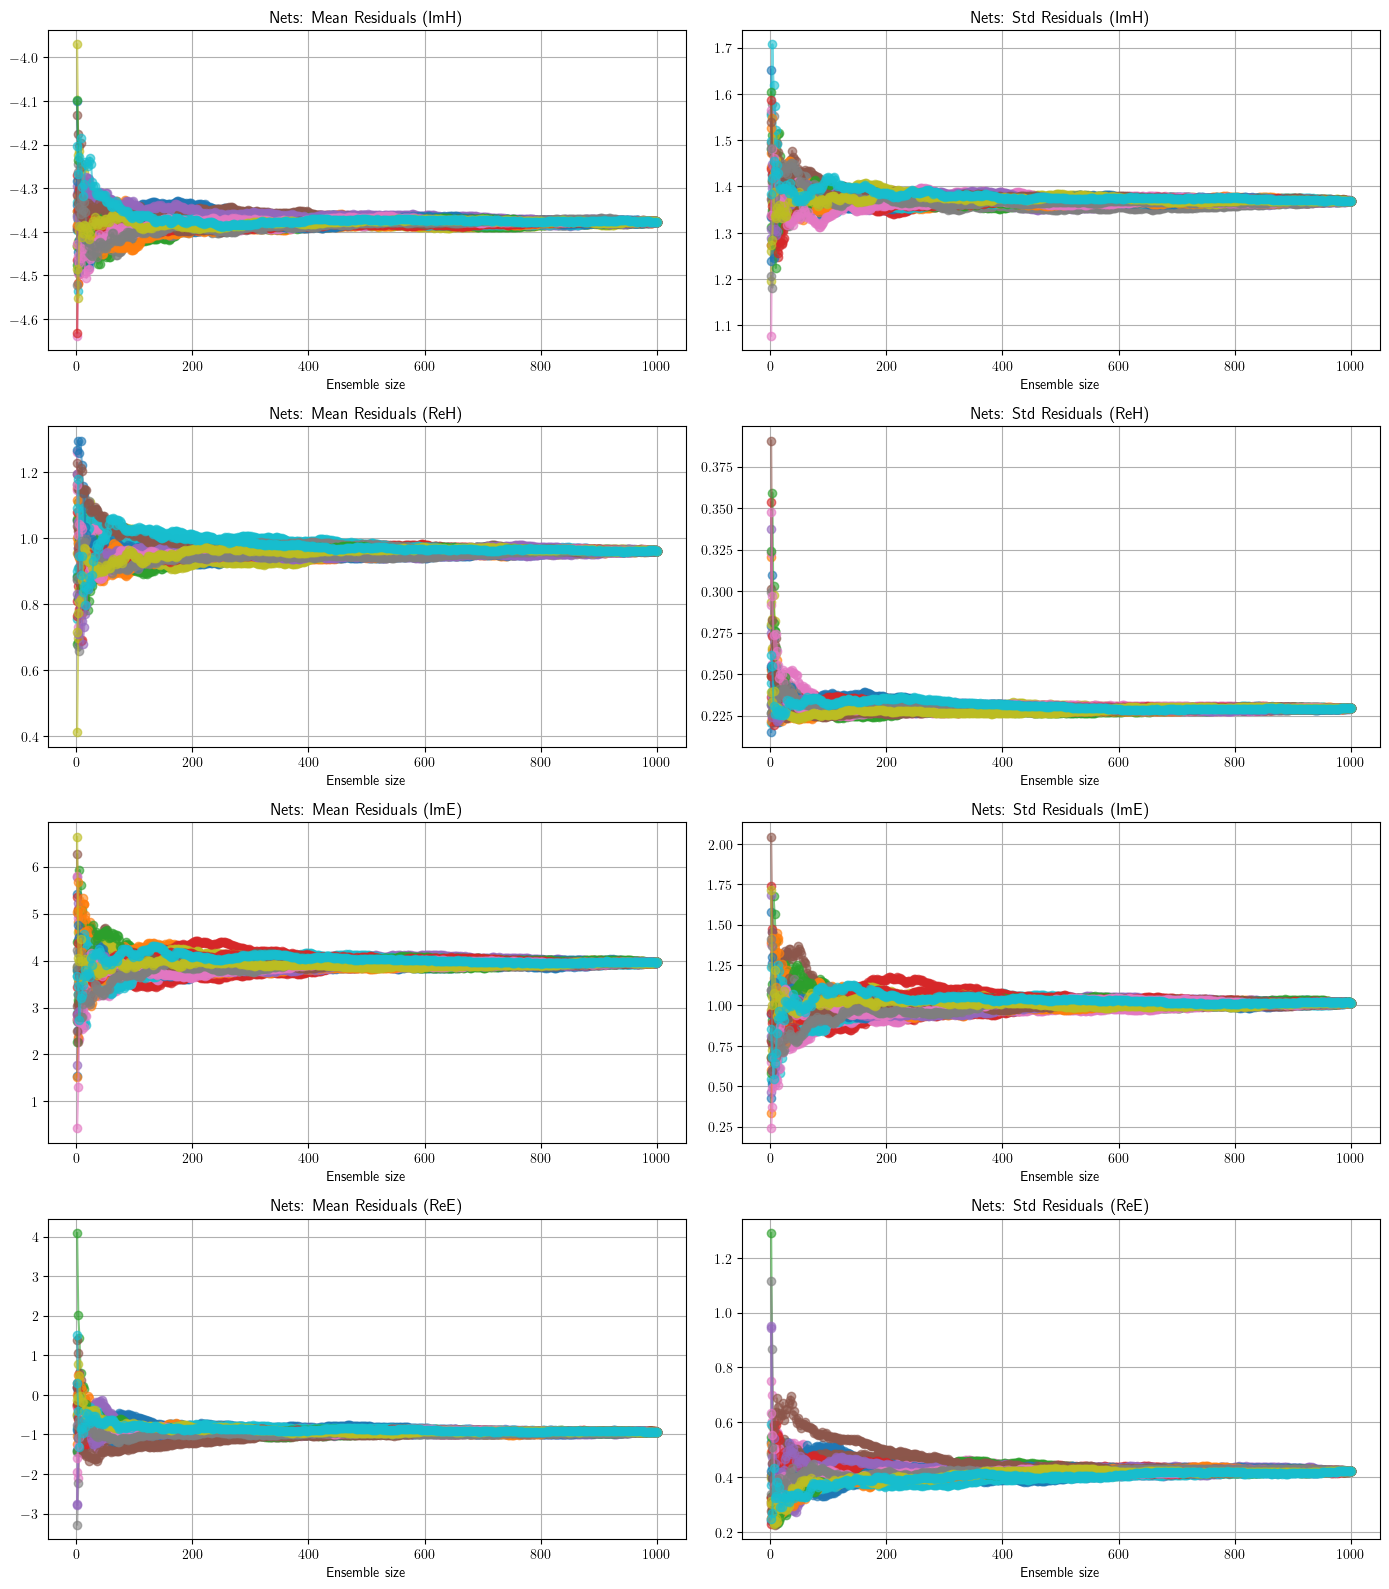


📈 Plotting ensemble behavior over models...


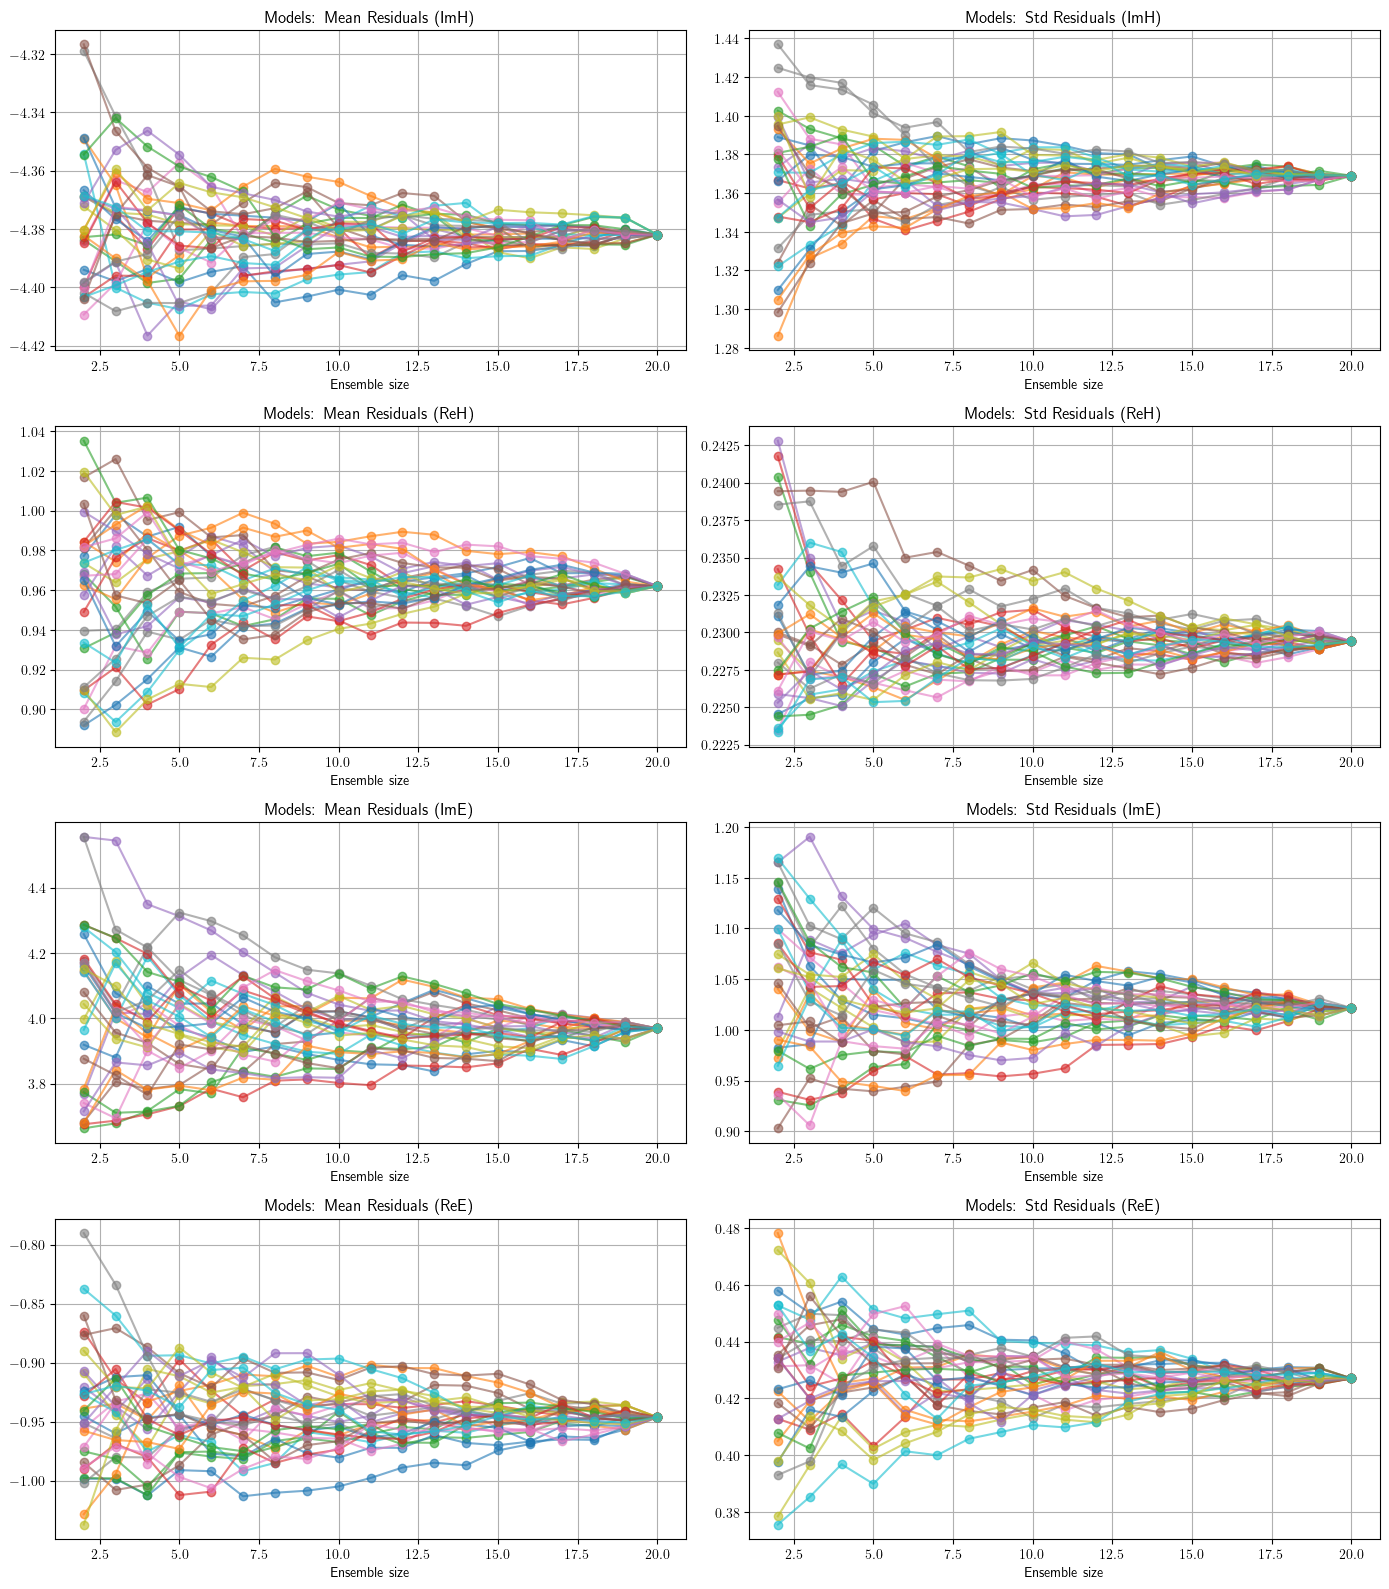

In [15]:
# ===============================================================
# STEP 4: Plot Results
# ===============================================================

print("\n📈 Plotting ensemble behavior over nets...")
evaluate_ensemble_behavior(
    ensemble_predictions_nets, 
    Data_pointsy, 
    n_remove=2, 
    n_trials=30, 
    output_labels=output_labels,
    title_prefix="Nets"
)

print("\n📈 Plotting ensemble behavior over models...")
evaluate_ensemble_behavior(
    ensemble_predictions_models, 
    Data_pointsy, 
    n_remove=1, 
    n_trials=30, 
    output_labels=output_labels,
    title_prefix="Models"
)

# CFF plots

### All models

In [16]:
# --- Configuration ---
ensembleSize = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_layer = ['ImH', 'ReH', 'ImE', 'ReE']
output_labels = ['ImH', 'ReH', 'ImE', 'ReE']

ensemble_paths = [os.path.join(FITS_DIR, f'nets_NoDR_{i}.pt') for i in range(1, ensembleSize + 1)]

In [17]:
# ===============================================================
# 1. Full Ensemble (all models + all nets)
# ===============================================================

class CombinedEnsembleModel_CFFs(NNTest):
    def __init__(self, ensemble_paths, output_layer, device='cpu'):
        super().__init__(output_layer=output_layer)
        self.device = device
        self.nets = []

        for path in ensemble_paths:
            checkpoint = torch.load(path, map_location=device)
            nets = checkpoint['nets']
            self.nets.extend(nets)

        self.name = "NoDR Combined Full Ensemble"

    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):
        inputs = torch.tensor([[pt.xB, pt.t]], dtype=torch.float32).to(self.device)

        all_cff_preds = []
        for net, mean, std in self.nets:
            net = net.to(self.device)
            net.eval()
            x_standardized = (inputs - mean) / (std + 1e-7)
            cff_pred = net(x_standardized)[0].cpu().detach().numpy()
            all_cff_preds.append(cff_pred)

        all_cff_preds = np.stack(all_cff_preds)
        idx = self.cffs_map[pt.observable]

        if mesh:
            return all_cff_preds[:, idx]

        mean_pred = np.mean(all_cff_preds[:, idx])
        std_pred = np.std(all_cff_preds[:, idx])

        if uncertainty:
            return mean_pred, std_pred, std_pred
        else:
            return mean_pred

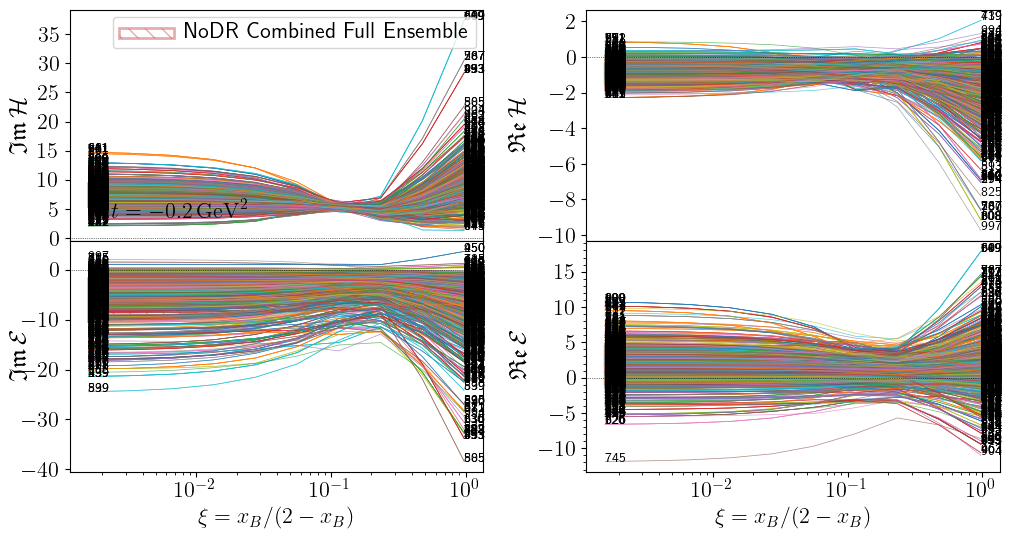

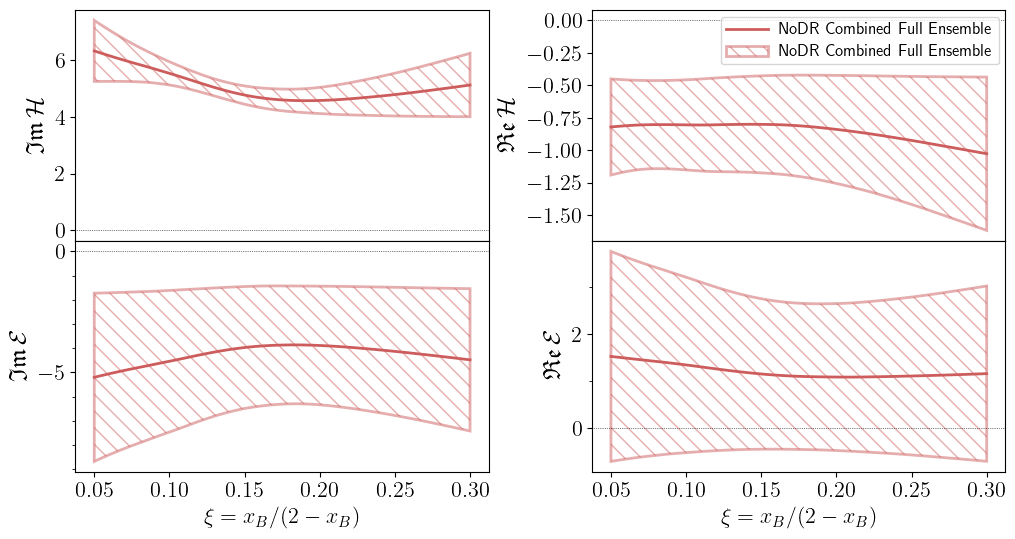

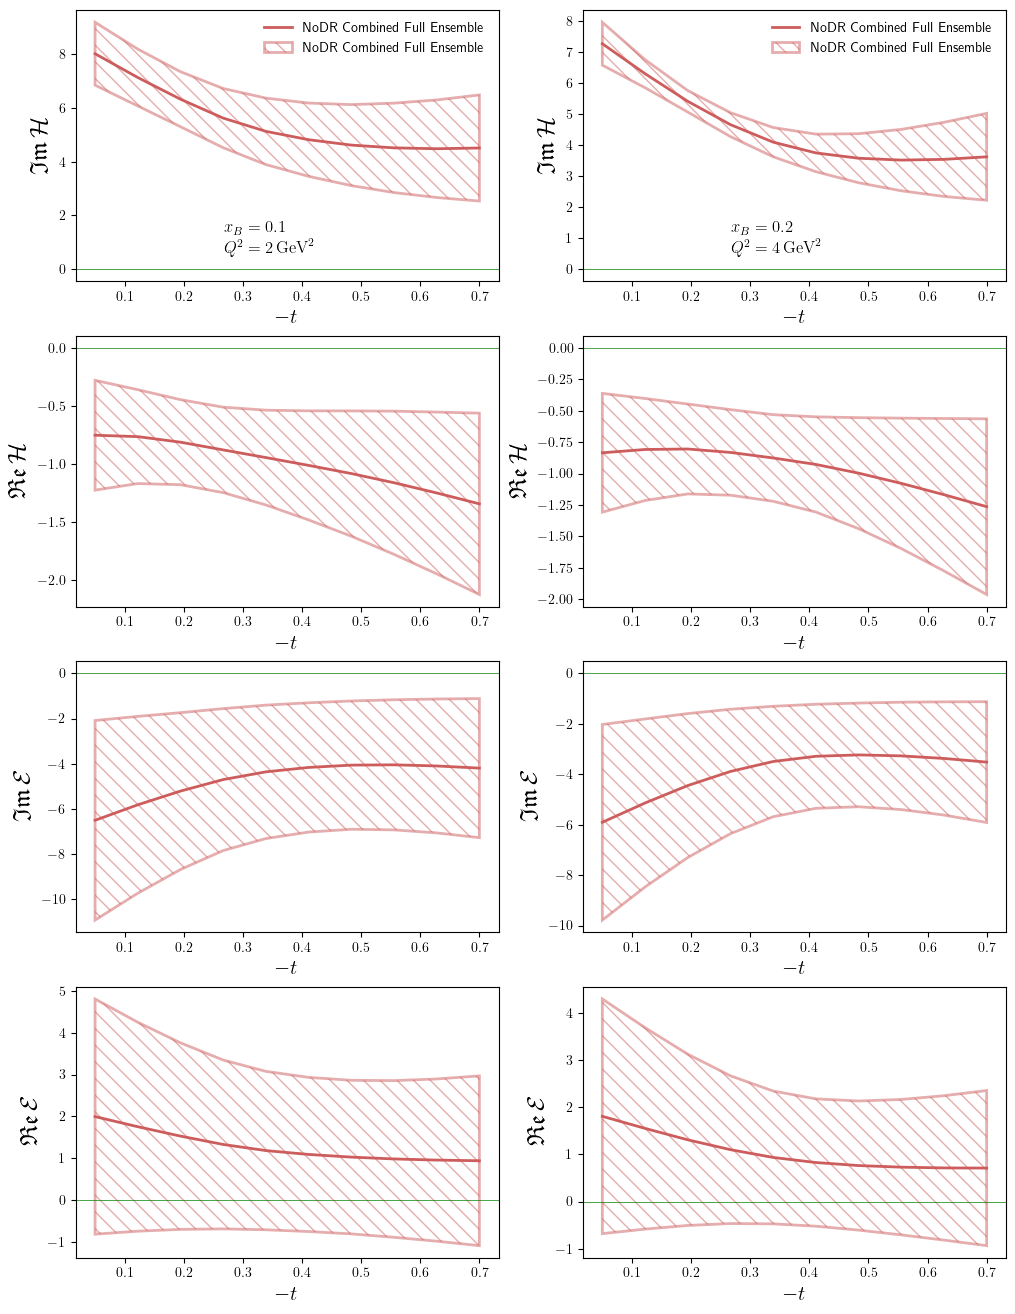

In [18]:
# --- Build and Plot full ensemble ---

th_combined_full = CombinedEnsembleModel_CFFs(ensemble_paths=ensemble_paths, output_layer=output_layer, device=device)

fig = gplot.CFF3log(cffs=output_layer, mesh=th_combined_full, bands=[th_combined_full], tval=-0.2)
#fig.savefig(os.path.join(RESULTS_DIR, "CFF3log_full_ensemble.png"))

fig = gplot.CFF3(cffs=output_layer, lines=[th_combined_full], bands=[th_combined_full])
#fig.savefig(os.path.join(RESULTS_DIR, "CFF3_full_ensemble.png"))

fig = gplot.CFFt(cffs=output_layer, lines=[th_combined_full], bands=[th_combined_full])
#fig.savefig(os.path.join(RESULTS_DIR, "CFFt_full_ensemble.png"))

### Best models

In [19]:
# ===============================================================
# 2. Best Models Only (mean prediction over best ensemble models)
# ===============================================================

# --- Analyze chisq per model ---
all_chisq = []
for i in tqdm(range(1, ensembleSize + 1), desc="Analyzing models"):
    path = os.path.join(FITS_DIR, f'nets_NoDR_{i}.pt')
    checkpoint = torch.load(path, map_location=device)

    th = NNTest(output_layer=checkpoint['output_layer'])
    th.nets = checkpoint['nets']

    chisq_total, npts, _ = th.chisq(fitpoints)
    all_chisq.append(chisq_total / npts)

all_chisq = np.array(all_chisq)

Analyzing models: 100%|██████████| 20/20 [41:49<00:00, 125.48s/it]


In [20]:
all_chisq

array([0.97529852, 0.94735703, 0.95087261, 0.97359239, 0.95463812,
       0.9603379 , 0.96251052, 0.959081  , 0.95239519, 0.95980081,
       0.9567116 , 0.95497048, 0.95313206, 0.95241811, 0.94819708,
       0.95518383, 0.95273187, 0.95156657, 0.95069404, 0.94546206])

In [21]:
# --- Select good models ---
threshold_model = 1.1
best_model_indices = np.where(all_chisq < threshold_model)[0]

print(f"✅ Selected {len(best_model_indices)} good models out of {ensembleSize}")

# --- Build combined model (Best Models) ---

class CombinedBestModels(NNTest):
    def __init__(self, ensemble_paths, selected_indices, output_layer, device='cpu'):
        super().__init__(output_layer=output_layer)
        self.device = device
        self.nets = []

        for idx in selected_indices:
            checkpoint = torch.load(ensemble_paths[idx], map_location=device)
            nets = checkpoint['nets']
            self.nets.extend(nets)

        self.name = "NoDR Ensemble - Best Models"

    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):
        inputs = torch.tensor([[pt.xB, pt.t]], dtype=torch.float32).to(self.device)

        all_cff_preds = []
        for net, mean, std in self.nets:
            net = net.to(self.device)
            net.eval()
            x_standardized = (inputs - mean) / (std + 1e-7)
            cff_pred = net(x_standardized)[0].cpu().detach().numpy()
            all_cff_preds.append(cff_pred)

        all_cff_preds = np.stack(all_cff_preds)
        idx = self.cffs_map[pt.observable]

        if mesh:
            return all_cff_preds[:, idx]

        mean_pred = np.mean(all_cff_preds[:, idx])
        std_pred = np.std(all_cff_preds[:, idx])

        if uncertainty:
            return mean_pred, std_pred, std_pred
        else:
            return mean_pred

✅ Selected 20 good models out of 20


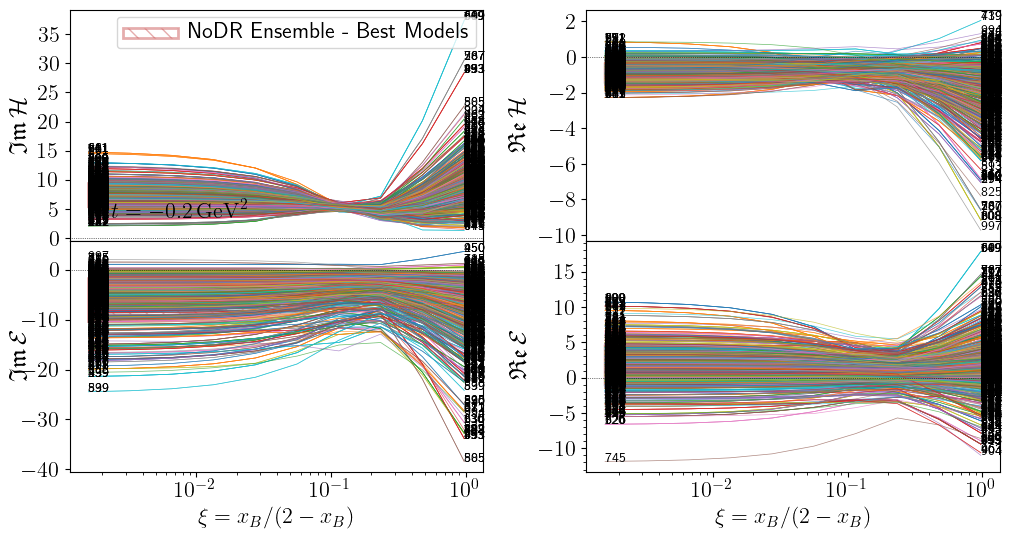

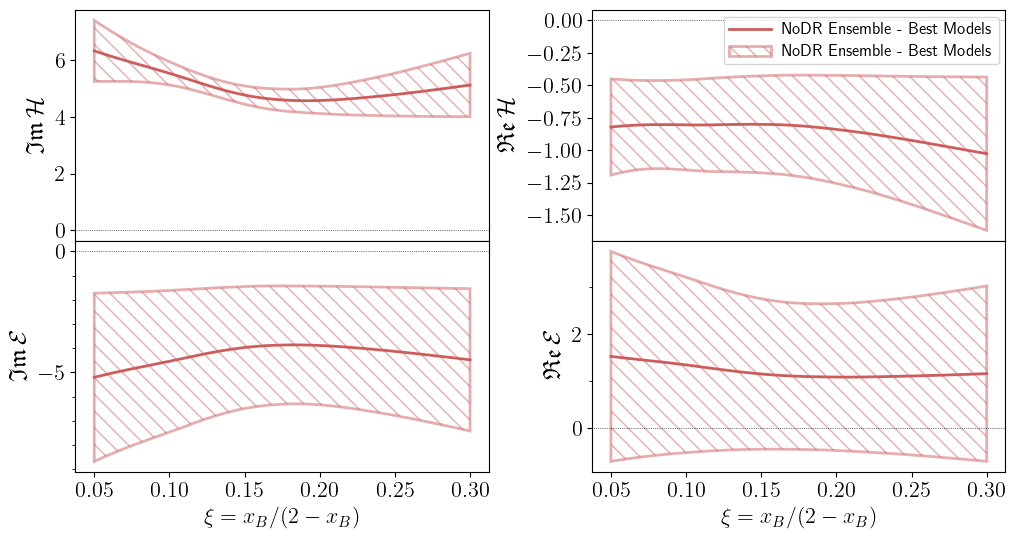

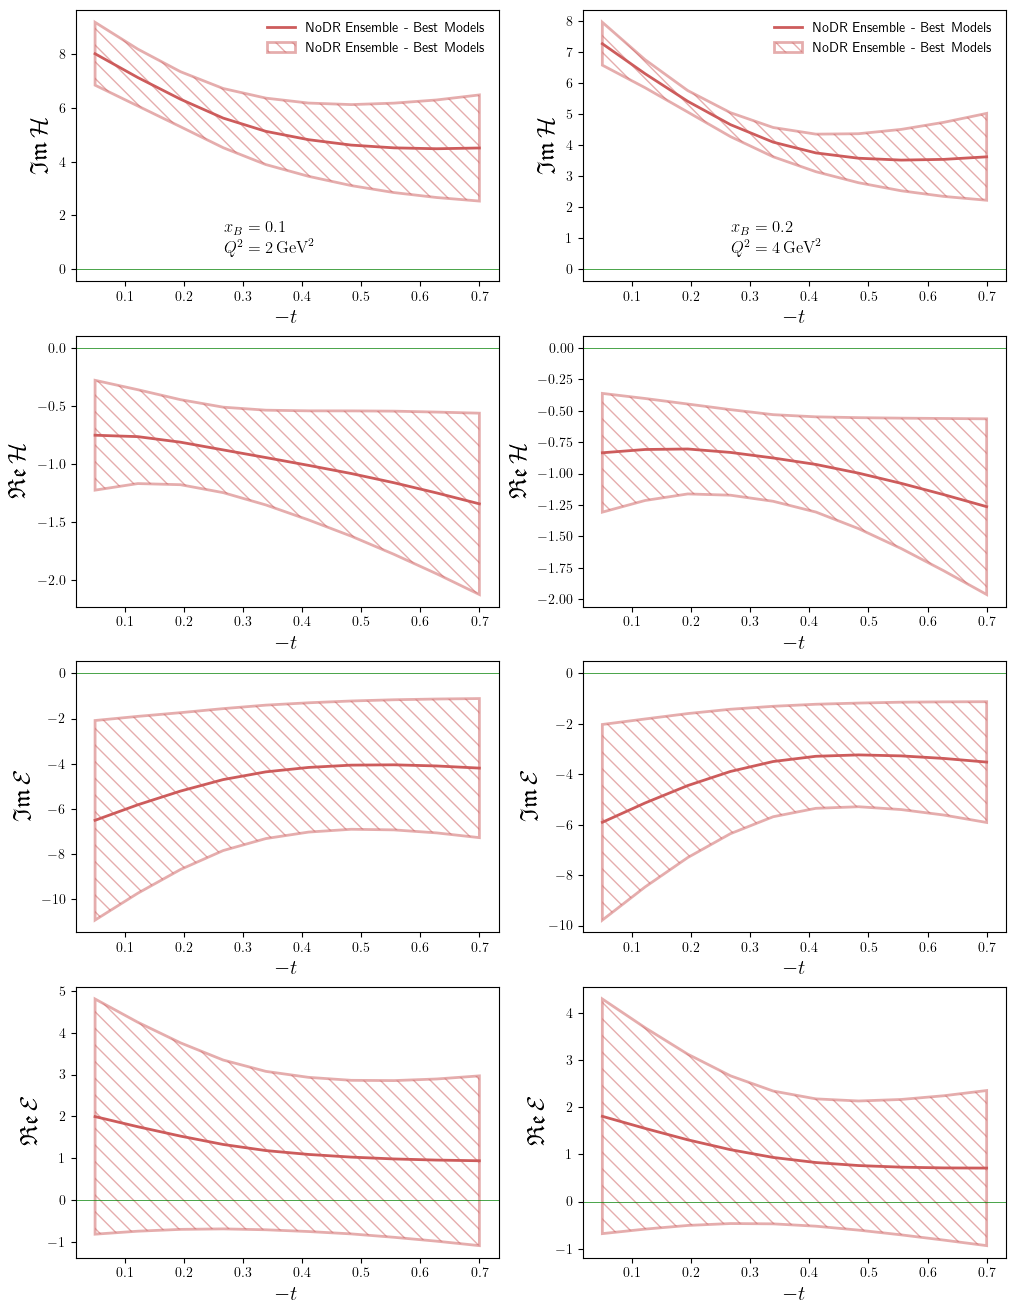

In [22]:
# --- Build and plot best models combined ---

th_combined_best_models = CombinedBestModels(ensemble_paths=ensemble_paths, selected_indices=best_model_indices, output_layer=output_layer)

fig = gplot.CFF3log(cffs=output_layer, mesh=th_combined_best_models, bands=[th_combined_best_models], tval=-0.2)
#fig.savefig(os.path.join(RESULTS_DIR, "CFF3log_best_models.png"))

fig = gplot.CFF3(cffs=output_layer, lines=[th_combined_best_models], bands=[th_combined_best_models])
#fig.savefig(os.path.join(RESULTS_DIR, "CFF3_best_models.png"))

fig = gplot.CFFt(cffs=output_layer, lines=[th_combined_best_models], bands=[th_combined_best_models])
#fig.savefig(os.path.join(RESULTS_DIR, "CFFt_best_models.png"))

### Best nets

In [23]:
# ===============================================================
# 3. Best Nets Only (analyzing all nets separately)
# ===============================================================

# --- Collect chi² for all individual nets ---
all_cff_chisq = []
all_cff_preds = []

for i in tqdm(range(1, ensembleSize + 1), desc="Analyzing nets"):
    path = os.path.join(FITS_DIR, f'nets_NoDR_{i}.pt')
    checkpoint = torch.load(path, map_location=device)
    output_layer_net = checkpoint['output_layer']

    for net, mean, std in checkpoint['nets']:
        th_net = NNTest(output_layer=output_layer_net)
        th_net.nn_model = net
        th_net.nn_mean = mean
        th_net.nn_std = std
        th_net.nets = [(net, mean, std)]

        chisq_val, npts, _ = th_net.chisq(fitpoints)
        chisq_val_per_point = chisq_val / npts
        all_cff_chisq.append(chisq_val_per_point)

        all_cff_preds.append((net, mean, std))

all_cff_chisq = np.array(all_cff_chisq)

Analyzing nets: 100%|██████████| 20/20 [41:15<00:00, 123.78s/it]


In [24]:
all_cff_chisq

array([1.41058366, 1.19284783, 0.97414855, 0.98504959, 1.0791992 ,
       1.0042637 , 1.41392481, 1.0105988 , 1.04343136, 1.20402181,
       1.02276521, 1.09948769, 1.0382979 , 1.03328338, 0.99185008,
       1.13219266, 1.12349406, 1.01274007, 0.99427312, 1.0689503 ,
       0.94127111, 1.06864558, 0.96691425, 1.18315531, 1.04561658,
       0.99688809, 1.30808983, 1.0421503 , 1.15810619, 1.07578583,
       1.00171504, 1.00540649, 1.12563051, 0.98965044, 1.09732428,
       1.04790704, 1.05842139, 1.10645144, 1.15024563, 1.07123554,
       1.02192235, 1.06318847, 1.0379506 , 1.4053592 , 1.0233114 ,
       1.11477579, 0.99950374, 1.07764113, 1.34765935, 1.05863099,
       0.95162918, 1.02737925, 1.18672219, 1.01715341, 1.02003021,
       1.01599858, 1.00853681, 1.13740406, 1.05680768, 1.03290811,
       0.96962699, 1.33294407, 0.99699342, 1.04712799, 1.05284343,
       1.0582727 , 1.02752881, 0.98837226, 1.47409265, 1.30442246,
       1.19707365, 1.13349862, 1.21840374, 1.03774357, 0.95543

In [25]:
# --- Select good nets ---
threshold_net = 1.1

good_net_indices = np.where(all_cff_chisq < threshold_net)[0]

print(f"✅ Selected {len(good_net_indices)} good nets out of {len(all_cff_preds)}")

# --- Build combined model (Best Nets) ---

class CombinedGoodNets(NNTest):
    def __init__(self, all_nets, selected_indices, output_layer, device='cpu'):
        super().__init__(output_layer=output_layer)
        self.device = device
        self.nets = [all_nets[i] for i in selected_indices]
        self.name = "NoDR Ensemble - Best Nets"

    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):
        inputs = torch.tensor([[pt.xB, pt.t]], dtype=torch.float32).to(self.device)

        all_cff_preds = []
        for net, mean, std in self.nets:
            net = net.to(self.device)
            net.eval()
            x_standardized = (inputs - mean) / (std + 1e-7)
            cff_pred = net(x_standardized)[0].cpu().detach().numpy()
            all_cff_preds.append(cff_pred)

        all_cff_preds = np.stack(all_cff_preds)
        idx = self.cffs_map[pt.observable]

        if mesh:
            return all_cff_preds[:, idx]

        mean_pred = np.mean(all_cff_preds[:, idx])
        std_pred = np.std(all_cff_preds[:, idx])

        if uncertainty:
            return mean_pred, std_pred, std_pred
        else:
            return mean_pred

✅ Selected 702 good nets out of 1000


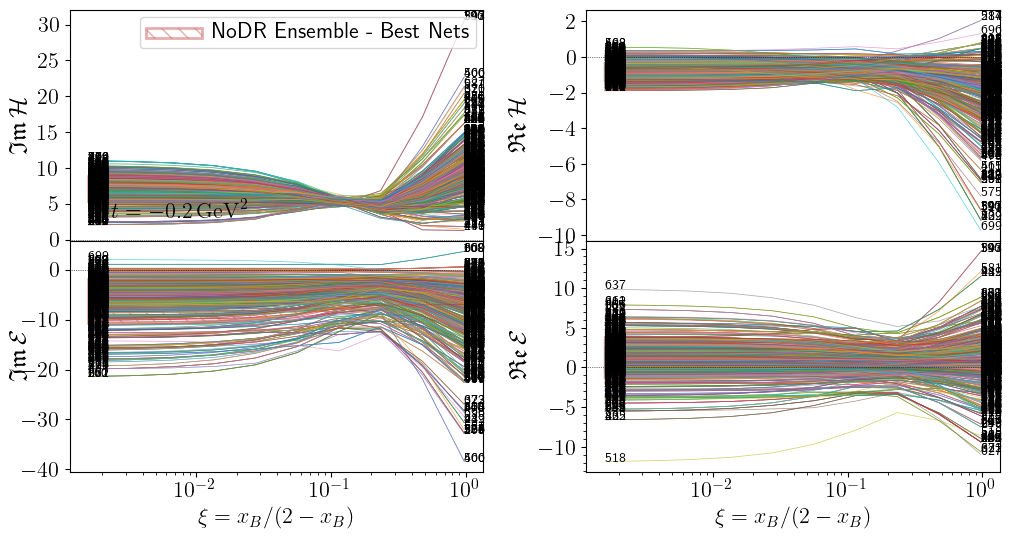

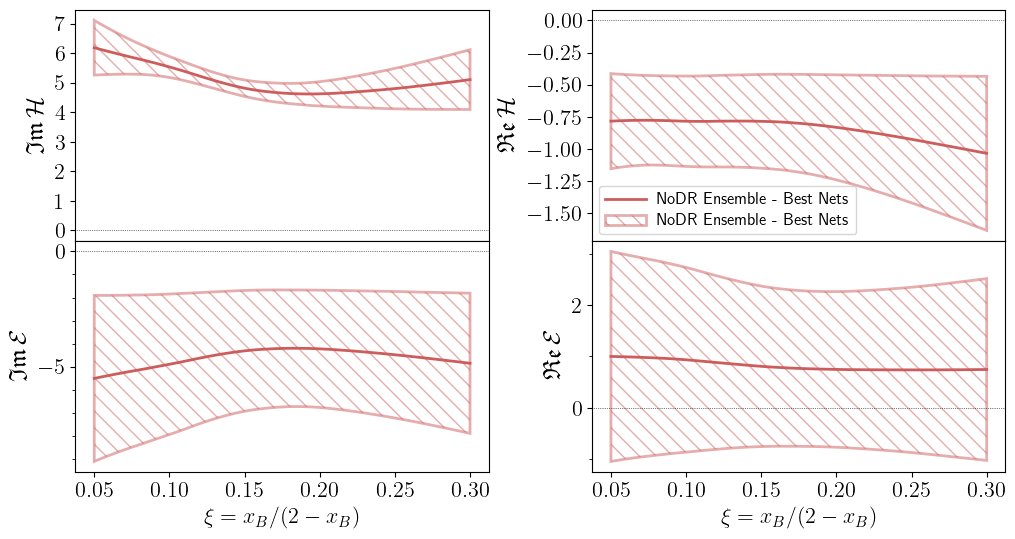

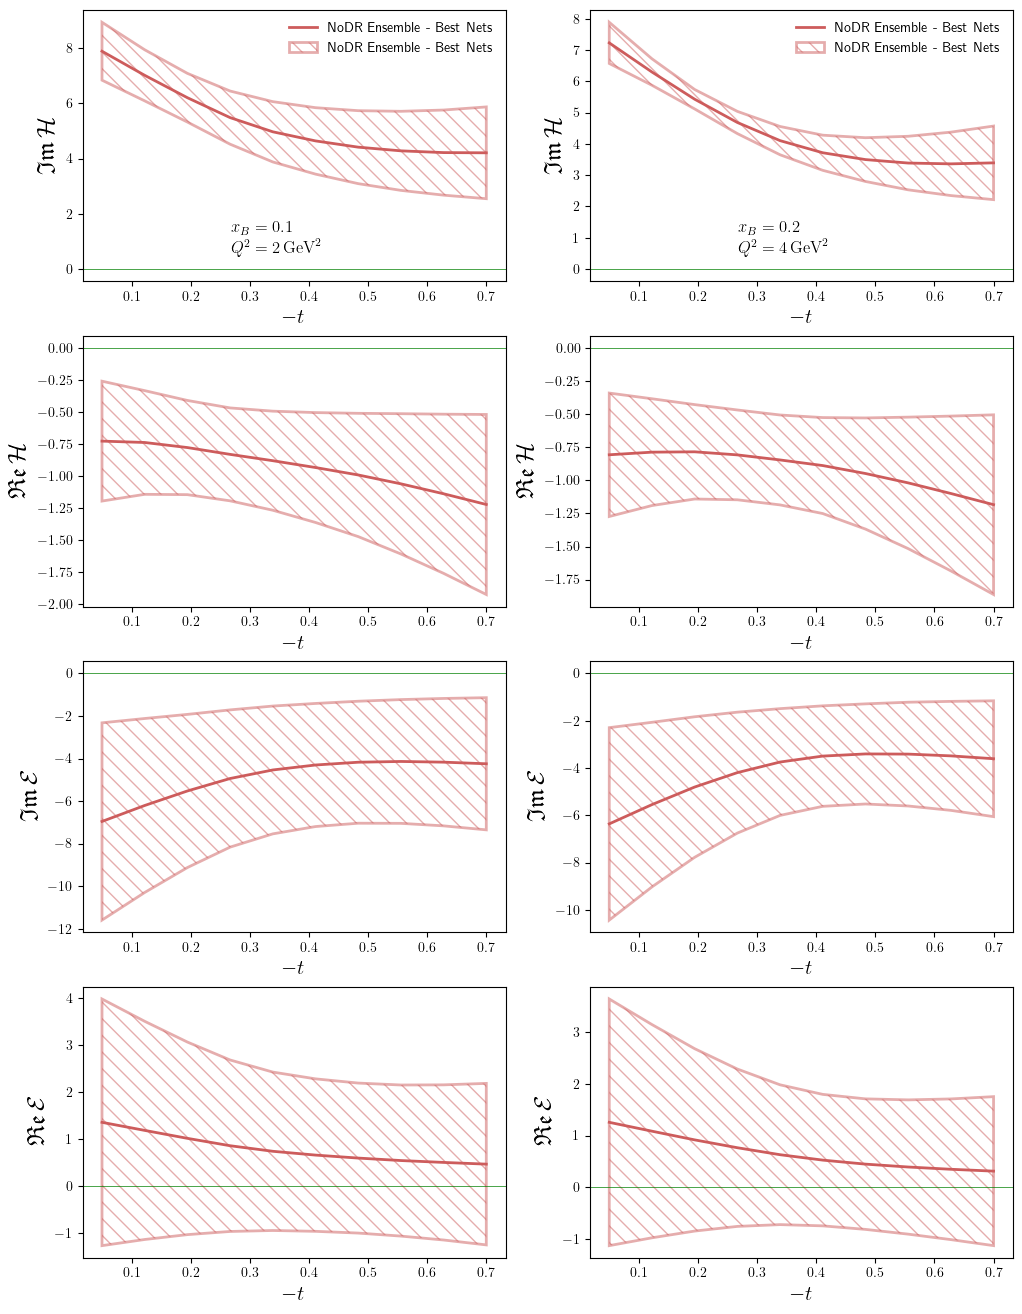

In [26]:
# --- Build and plot best nets combined ---

th_combined_best_nets = CombinedGoodNets(all_nets=all_cff_preds, selected_indices=good_net_indices, output_layer=output_layer)

fig = gplot.CFF3log(cffs=output_layer, mesh=th_combined_best_nets, bands=[th_combined_best_nets], tval=-0.2)
#fig.savefig(os.path.join(RESULTS_DIR, "CFF3log_best_nets.png"))

fig = gplot.CFF3(cffs=output_layer, lines=[th_combined_best_nets], bands=[th_combined_best_nets])
#fig.savefig(os.path.join(RESULTS_DIR, "CFF3_best_nets.png"))

fig = gplot.CFFt(cffs=output_layer, lines=[th_combined_best_nets], bands=[th_combined_best_nets])
#fig.savefig(os.path.join(RESULTS_DIR, "CFFt_best_nets.png"))

In [27]:
def save_combined_fit(model, filename):
    save_dict = {
        "nets": model.nets,
        "output_layer": model.output_layer,
        "name": model.name,
    }
    torch.save(save_dict, os.path.join(FITS_DIR, filename))
    print(f"✅ Saved {model.name} to {filename}")

# Save both:
save_combined_fit(th_combined_best_nets, "th_combined_goodnets.pt")
save_combined_fit(th_combined_best_models, "th_combined_bestmodels.pt")

✅ Saved NoDR Ensemble - Best Nets to th_combined_goodnets.pt
✅ Saved NoDR Ensemble - Best Models to th_combined_bestmodels.pt
